In [1]:
# import all necessary stuff
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np

In [2]:
# import and read in CSV
amazon_data_path = "Resources/Amazon_Data.csv"

amazon_data = pd.read_csv(amazon_data_path, delimiter=',', header=0)

In [3]:
# create starter data frame from CSV
amazon_df = pd.DataFrame(amazon_data)

amazon_df.head()

,Index,Timestamp,age,Gender,Purchase_Frequency,Purchase_Categories,Personalized_Recommendation_Frequency,Browsing_Frequency,Product_Search_Method,Search_Result_Exploration,...,Saveforlater_Frequency,Review_Left,Review_Reliability,Review_Helpfulness,Personalized_Recommendation_Frequency,Recommendation_Helpfulness,Rating_Accuracy,Shopping_Satisfaction,Service_Appreciation,Improvement_Areas
0,1,2023/06/04 1:28:19 PM GMT+5:30,23,Female,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,...,Sometimes,Yes,Occasionally,Yes,2,Yes,1,1,Competitive prices,Reducing packaging waste
1,2,2023/06/04 1:28:19 PM GMT+5:31,23,Female,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,...,Rarely,No,Heavily,Yes,2,Sometimes,3,2,Wide product selection,Reducing packaging waste
2,3,2023/06/04 1:28:19 PM GMT+5:32,24,Prefer not to say,Few times a month,"Groceries and Gourmet Food,Clothing and Fashion",No,Few times a month,Keyword,Multiple pages,...,Rarely,No,Occasionally,No,4,No,3,3,Competitive prices,Product quality and accuracy
3,4,2023/06/04 1:28:19 PM GMT+5:33,24,Female,Once a month,"Beauty and Personal Care,Clothing and Fashion,...",Sometimes,Few times a month,Keyword,First page,...,Sometimes,Yes,Heavily,Yes,3,Sometimes,3,4,Competitive prices,Product quality and accuracy
4,5,2023/06/04 1:28:19 PM GMT+5:34,22,Female,Less than once a month,"Beauty and Personal Care,Clothing and Fashion",Yes,Few times a month,Filter,Multiple pages,...,Rarely,No,Heavily,Yes,4,Yes,2,2,Competitive prices,Product quality and accuracy


In [4]:
# rename columns
amazon_df = amazon_df.rename(columns={"Personalized_Recommendation_Frequency":"Recommendation_Frequency",
                              "Product_Search_Method":"Search_Method",
                              "Search_Result_Exploration":"Exploration",
                              "Saveforlater_Frequency":"Save_for_Later_Frequency",
                              "age":"Age"})
amazon_df.head()

# define variables as dictionaries or lists here
age = amazon_df["Age"]
print(age)

0      23
1      23
2      24
3      24
4      22
       ..
597    23
598    23
599    23
600    23
601    23
Name: Age, Length: 602, dtype: int64


In [5]:
# Question 1: Is there a strong correlation with age group and purchasing frequency on Amazon? – Maia

# group the ages and compare group sizes - population is skewed very young, maybe binning?









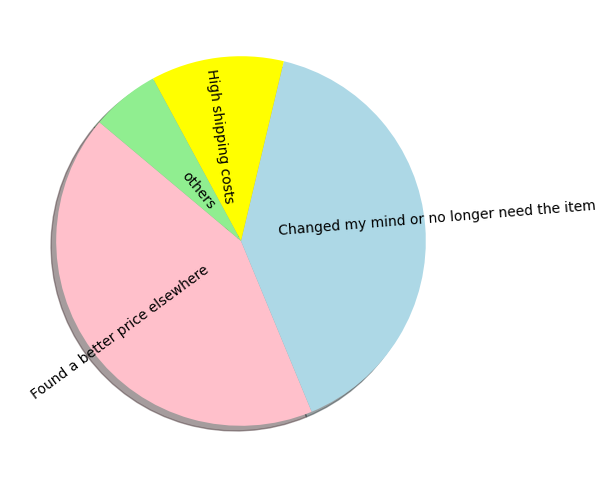

In [15]:
# Question 2: Investigate top factors for cart abandonment – Kyle
abandon_counts= amazon_df["Cart_Abandonment_Factors"].value_counts()
#, autopct="%1.1f%%"
colors = ["pink", "lightblue", "yellow", "lightgreen", 'orange']
count_chart = abandon_counts.plot(kind='pie', figsize=(6,6), colors=colors, shadow=True, 
                                  startangle=140, rotatelabels=True, labeldistance=0.20)
plt.ylabel("")
plt.show()
plt.tight_layout()


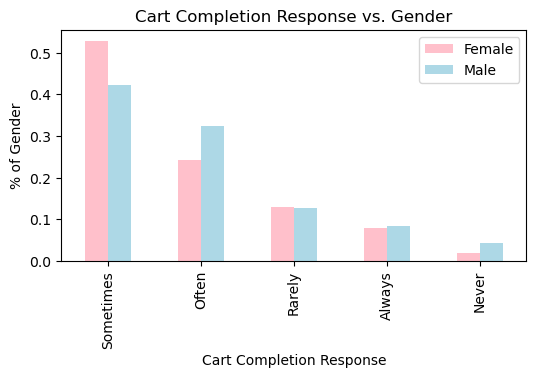

<Figure size 640x480 with 0 Axes>

In [7]:
gender_dataset = amazon_df
# Drop unwanted responses for Gender
gender_dataset = gender_dataset.drop(gender_dataset[gender_dataset["Gender"] == "Prefer not to say"].index)
gender_dataset = gender_dataset.drop(gender_dataset[gender_dataset["Gender"] == "Others"].index)

# Group by Gender and find counts of responses as a % of the total responses for each gender
gender_abandonment = gender_dataset.groupby(["Gender"])
gender_abandonment = gender_abandonment["Cart_Completion_Frequency"].value_counts()
gender_count = gender_dataset["Gender"].value_counts()
gender_abandonment = gender_abandonment/gender_count
gender_abandonment = gender_abandonment.reset_index()

# Break down group into male and female counts
female_abandonment = gender_abandonment.drop(gender_abandonment[gender_abandonment["Gender"] == "Male"].index)
female_abandonment = female_abandonment.reset_index(drop=True)
male_abandonment = gender_abandonment.drop(gender_abandonment[gender_abandonment["Gender"] == "Female"].index)
male_abandonment = male_abandonment.reset_index(drop=True)

# Merge back into one dataframe for graphing
abandonment_df = pd.merge(female_abandonment, male_abandonment, how="left", on=["Cart_Completion_Frequency", "Cart_Completion_Frequency"])

# Clean up merged dataframe
abandonment_df = abandonment_df.rename(columns={"count_x":"Female",
                              "count_y":"Male"})
abandonment_df = abandonment_df.drop(["Gender_x", "Gender_y"], axis=1)
abandonment_df = abandonment_df.set_index("Cart_Completion_Frequency")

# Create chart
count_chart = abandonment_df.plot(kind='bar', figsize=(6,3), color =["pink", "lightblue"])
plt.title("Cart Completion Response vs. Gender")
count_chart.set_xlabel("Cart Completion Response")
count_chart.set_ylabel("% of Gender")
plt.show()
plt.tight_layout()


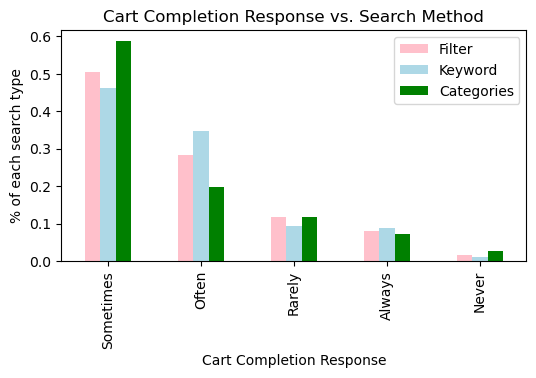

<Figure size 640x480 with 0 Axes>

In [8]:
# Create new df for searches

search_dataset = amazon_df
# Drop unwanted searches

search_dataset = search_dataset.drop(search_dataset[search_dataset["Search_Method"] == "others"].index)

# Group by search method and then get percentages of each response
search_abandonment = search_dataset.groupby(["Search_Method"])
search_abandonment = search_abandonment["Cart_Completion_Frequency"].value_counts()
search_count = search_dataset["Search_Method"].value_counts()
search_abandonment = search_abandonment/search_count

# Reset the index
search_abandonment = search_abandonment.reset_index()

# Extract each search type and reset the index
filter_search = search_abandonment.loc[(search_abandonment["Search_Method"] == "Filter"), :]
filter_search = filter_search.reset_index(drop=True)
keyword_search = search_abandonment.loc[(search_abandonment["Search_Method"] == "Keyword"), :]
keyword_search = keyword_search.reset_index(drop=True)
categories_search = search_abandonment.loc[(search_abandonment["Search_Method"] == "categories"), :]
categories_search = categories_search.reset_index(drop=True)

# Merge all search types into one dataframe and clean the columns
search_df = pd.merge(filter_search, keyword_search, how="left", on=["Cart_Completion_Frequency", "Cart_Completion_Frequency"])
search_df = pd.merge(search_df, categories_search, how="left", on=["Cart_Completion_Frequency", "Cart_Completion_Frequency"])
search_df = search_df.rename(columns={"count_x":"Filter",
                              "count_y":"Keyword", "count":"Categories"})
search_df = search_df.drop(["Search_Method_x", "Search_Method_y", "Search_Method"], axis=1)
search_df = search_df.set_index("Cart_Completion_Frequency")

# Create Chart
count_chart = search_df.plot(kind='bar', figsize=(6,3), color =["pink", "lightblue", "green"])
plt.title("Cart Completion Response vs. Search Method")
count_chart.set_xlabel("Cart Completion Response")
count_chart.set_ylabel("% of each search type")
plt.show()
plt.tight_layout()

In [9]:
# Question 3: Review question – Eileen. Which type of consumer leaves the most reviews? The least?


#just a test!  







In [10]:
# Question 4: Is there a strong correlation between browsing frequency and purchase frequency?








